# Method 6 - Best Ideas Low Concentration

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Herfindahl

inst_data['target_sq'] = inst_data['target'] ** 2
herf = inst_data.groupby(['datadate', 'institution_id'])['target_sq'].sum().rename('herf').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns from Market Relative Weight per Shumway, Szefler, Yuan 2009

%store -r mkt_exp_ret

valid_data = valid_data.merge(mkt_exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Herf

best_ideas = best_ideas.merge(herf)
best_ideas['herf_pct'] = best_ideas.groupby('datadate')['herf'].rank(pct=True)
best_ideas = best_ideas[best_ideas['herf_pct'] < (1 / 3)]

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

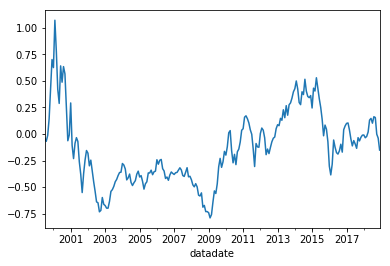

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.700040
2000-12-31   -0.417218
2001-12-31   -0.147641
2002-12-31   -0.599013
2003-12-31    0.890818
2004-12-31    0.015518
2005-12-31    0.000091
2006-12-31   -0.032728
2007-12-31   -0.042951
2008-12-31   -0.551754
2009-12-31    2.099580
2010-12-31    0.237765
2011-12-31   -0.154664
2012-12-31    0.200482
2013-12-31    0.329257
2014-12-31   -0.025196
2015-12-31   -0.319057
2016-12-31    0.160781
2017-12-31   -0.080866
2018-12-31   -0.142200
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     167.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.11e-67
Time:                        13:55:27   Log-Likelihood:                 316.17
No. Observations:                 234   AIC:                            -622.3
Df Residuals:                     229   BIC:                            -605.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0044      0.004      1.023      0.307      -0.004       0.013
mktrf          1.3678      0.118     11.579      0.000       1.135       1.601
me             0.7231      0.137      5.263      0.000       0.452       0.994
ia            -0.0820      0.209     -0.393      0.695      -0.494       0.329
roe           -1.5803      0.179     -8.840      0.000      -1.932      -1.228
==============================================================================
Omnibus:                      142.156   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1573.661
Skew:                           2.167   Prob(JB):                         0.00
Kurtosis:                      14.942   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     74.67
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.03e-40
Time:                        13:55:27   Log-Likelihood:                 316.17
No. Observations:                 234   AIC:                            -622.3
Df Residuals:                     229   BIC:                            -605.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0044      0.005      0.959      0.337      -0.005       0.013
mktrf          1.3678      0.228      5.997      0.000       0.921       1.815
me             0.7231      0.152      4.772      0.000       0.426       1.020
ia            -0.0820      0.272     -0.302      0.763      -0.615       0.451
roe           -1.5803      0.270     -5.851      0.000      -2.110      -1.051
==============================================================================
Omnibus:                      142.156   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1573.661
Skew:                           2.167   Prob(JB):                         0.00
Kurtosis:                      14.942   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     85.17
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.35e-44
Time:                        13:55:27   Log-Likelihood:                 316.17
No. Observations:                 234   AIC:                            -622.3
Df Residuals:                     229   BIC:                            -605.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0044      0.005      0.879      0.379      -0.005       0.014
mktrf          1.3678      0.226      6.058      0.000       0.925       1.810
me             0.7231      0.169      4.281      0.000       0.392       1.054
ia            -0.0820      0.274     -0.299      0.765      -0.620       0.455
roe           -1.5803      0.286     -5.517      0.000      -2.142      -1.019
==============================================================================
Omnibus:                      142.156   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1573.661
Skew:                           2.167   Prob(JB):                         0.00
Kurtosis:                      14.942   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.725
Model:                            OLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     120.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.20e-62
Time:                        13:55:27   Log-Likelihood:                 307.00
No. Observations:                 234   AIC:                            -602.0
Df Residuals:                     228   BIC:                            -581.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.005      0.703      0.483      -0.006       0.012
mktrf          1.5210      0.123     12.330      0.000       1.278       1.764
smb            0.7948      0.163      4.883      0.000       0.474       1.115
hml            0.1759      0.192      0.917      0.360      -0.202       0.554
rmw           -1.3919      0.217     -6.414      0.000      -1.819      -0.964
cma           -0.0609      0.276     -0.221      0.825      -0.604       0.483
==============================================================================
Omnibus:                      134.941   Durbin-Watson:                   1.934
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1019.893
Skew:                           2.182   Prob(JB):                    3.41e-222
Kurtosis:                      12.250   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.725
Model:                            OLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     70.67
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.02e-44
Time:                        13:55:27   Log-Likelihood:                 307.00
No. Observations:                 234   AIC:                            -602.0
Df Residuals:                     228   BIC:                            -581.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.005      0.651      0.515      -0.006       0.013
mktrf          1.5210      0.156      9.741      0.000       1.215       1.827
smb            0.7948      0.173      4.607      0.000       0.457       1.133
hml            0.1759      0.331      0.531      0.595      -0.473       0.825
rmw           -1.3919      0.276     -5.051      0.000      -1.932      -0.852
cma           -0.0609      0.364     -0.167      0.867      -0.774       0.652
==============================================================================
Omnibus:                      134.941   Durbin-Watson:                   1.934
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1019.893
Skew:                           2.182   Prob(JB):                    3.41e-222
Kurtosis:                      12.250   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.725
Model:                            OLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     76.66
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.91e-47
Time:                        13:55:27   Log-Likelihood:                 307.00
No. Observations:                 234   AIC:                            -602.0
Df Residuals:                     228   BIC:                            -581.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.005      0.595      0.552      -0.007       0.014
mktrf          1.5210      0.140     10.887      0.000       1.247       1.795
smb            0.7948      0.171      4.655      0.000       0.460       1.129
hml            0.1759      0.279      0.631      0.528      -0.371       0.723
rmw           -1.3919      0.282     -4.944      0.000      -1.944      -0.840
cma           -0.0609      0.341     -0.179      0.858      -0.729       0.607
==============================================================================
Omnibus:                      134.941   Durbin-Watson:                   1.934
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1019.893
Skew:                           2.182   Prob(JB):                    3.41e-222
Kurtosis:                      12.250   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.732
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     156.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.37e-64
Time:                        13:55:27   Log-Likelihood:                 310.22
No. Observations:                 234   AIC:                            -610.4
Df Residuals:                     229   BIC:                            -593.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.004     -0.140      0.888      -0.009       0.008
mktrf          1.5869      0.112     14.225      0.000       1.367       1.807
smb            1.4679      0.139     10.541      0.000       1.194       1.742
hml           -0.2127      0.138     -1.537      0.126      -0.485       0.060
umd           -0.6068      0.091     -6.686      0.000      -0.786      -0.428
==============================================================================
Omnibus:                      121.008   Durbin-Watson:                   1.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1003.440
Skew:                           1.851   Prob(JB):                    1.28e-218
Kurtosis:                      12.446   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.732
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     100.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.26e-49
Time:                        13:55:27   Log-Likelihood:                 310.22
No. Observations:                 234   AIC:                            -610.4
Df Residuals:                     229   BIC:                            -593.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.004     -0.144      0.886      -0.009       0.008
mktrf          1.5869      0.181      8.758      0.000       1.232       1.942
smb            1.4679      0.129     11.375      0.000       1.215       1.721
hml           -0.2127      0.236     -0.900      0.368      -0.676       0.250
umd           -0.6068      0.142     -4.286      0.000      -0.884      -0.329
==============================================================================
Omnibus:                      121.008   Durbin-Watson:                   1.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1003.440
Skew:                           1.851   Prob(JB):                    1.28e-218
Kurtosis:                      12.446   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.732
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     90.11
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.89e-46
Time:                        13:55:27   Log-Likelihood:                 310.22
No. Observations:                 234   AIC:                            -610.4
Df Residuals:                     229   BIC:                            -593.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.004     -0.137      0.891      -0.009       0.008
mktrf          1.5869      0.173      9.172      0.000       1.248       1.926
smb            1.4679      0.125     11.708      0.000       1.222       1.714
hml           -0.2127      0.228     -0.933      0.351      -0.660       0.234
umd           -0.6068      0.142     -4.265      0.000      -0.886      -0.328
==============================================================================
Omnibus:                      121.008   Durbin-Watson:                   1.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1003.440
Skew:                           1.851   Prob(JB):                    1.28e-218
Kurtosis:                      12.446   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     85.18
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.81e-33
Time:                        13:55:27   Log-Likelihood:                 145.67
No. Observations:                 120   AIC:                            -281.3
Df Residuals:                     115   BIC:                            -267.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0107      0.007      1.517      0.132      -0.003       0.025
mktrf          1.2386      0.189      6.545      0.000       0.864       1.613
me             0.6171      0.187      3.302      0.001       0.247       0.987
ia            -0.4692      0.293     -1.603      0.112      -1.049       0.110
roe           -1.5267      0.259     -5.893      0.000      -2.040      -1.014
==============================================================================
Omnibus:                       73.043   Durbin-Watson:                   2.121
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              470.901
Skew:                           1.980   Prob(JB):                    5.56e-103
Kurtosis:                      11.860   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     67.89
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.20e-29
Time:                        13:55:27   Log-Likelihood:                 145.67
No. Observations:                 120   AIC:                            -281.3
Df Residuals:                     115   BIC:                            -267.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0107      0.007      1.589      0.112      -0.002       0.024
mktrf          1.2386      0.342      3.624      0.000       0.569       1.908
me             0.6171      0.199      3.107      0.002       0.228       1.006
ia            -0.4692      0.356     -1.317      0.188      -1.168       0.229
roe           -1.5267      0.362     -4.222      0.000      -2.235      -0.818
==============================================================================
Omnibus:                       73.043   Durbin-Watson:                   2.121
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              470.901
Skew:                           1.980   Prob(JB):                    5.56e-103
Kurtosis:                      11.860   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     79.78
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.91e-32
Time:                        13:55:27   Log-Likelihood:                 145.67
No. Observations:                 120   AIC:                            -281.3
Df Residuals:                     115   BIC:                            -267.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0107      0.007      1.521      0.128      -0.003       0.024
mktrf          1.2386      0.342      3.616      0.000       0.567       1.910
me             0.6171      0.218      2.830      0.005       0.190       1.045
ia            -0.4692      0.317     -1.481      0.139      -1.090       0.152
roe           -1.5267      0.401     -3.812      0.000      -2.312      -0.742
==============================================================================
Omnibus:                       73.043   Durbin-Watson:                   2.121
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              470.901
Skew:                           1.980   Prob(JB):                    5.56e-103
Kurtosis:                      11.860   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     64.53
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.22e-31
Time:                        13:55:27   Log-Likelihood:                 143.63
No. Observations:                 120   AIC:                            -275.3
Df Residuals:                     114   BIC:                            -258.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0102      0.007      1.384      0.169      -0.004       0.025
mktrf          1.6248      0.204      7.971      0.000       1.221       2.029
smb            0.7984      0.231      3.458      0.001       0.341       1.256
hml           -0.3680      0.283     -1.301      0.196      -0.928       0.192
rmw           -0.9298      0.334     -2.787      0.006      -1.591      -0.269
cma           -0.0517      0.365     -0.141      0.888      -0.776       0.672
==============================================================================
Omnibus:                       77.563   Durbin-Watson:                   1.936
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              406.304
Skew:                           2.261   Prob(JB):                     5.92e-89
Kurtosis:                      10.798   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     36.46
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.71e-22
Time:                        13:55:27   Log-Likelihood:                 143.63
No. Observations:                 120   AIC:                            -275.3
Df Residuals:                     114   BIC:                            -258.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0102      0.006      1.584      0.113      -0.002       0.023
mktrf          1.6248      0.268      6.070      0.000       1.100       2.149
smb            0.7984      0.237      3.365      0.001       0.333       1.263
hml           -0.3680      0.240     -1.530      0.126      -0.839       0.103
rmw           -0.9298      0.352     -2.639      0.008      -1.620      -0.239
cma           -0.0517      0.390     -0.132      0.895      -0.817       0.713
==============================================================================
Omnibus:                       77.563   Durbin-Watson:                   1.936
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              406.304
Skew:                           2.261   Prob(JB):                     5.92e-89
Kurtosis:                      10.798   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     46.14
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.54e-26
Time:                        13:55:27   Log-Likelihood:                 143.63
No. Observations:                 120   AIC:                            -275.3
Df Residuals:                     114   BIC:                            -258.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0102      0.007      1.471      0.141      -0.003       0.024
mktrf          1.6248      0.219      7.426      0.000       1.196       2.054
smb            0.7984      0.224      3.562      0.000       0.359       1.238
hml           -0.3680      0.168     -2.187      0.029      -0.698      -0.038
rmw           -0.9298      0.362     -2.570      0.010      -1.639      -0.221
cma           -0.0517      0.347     -0.149      0.881      -0.731       0.628
==============================================================================
Omnibus:                       77.563   Durbin-Watson:                   1.936
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              406.304
Skew:                           2.261   Prob(JB):                     5.92e-89
Kurtosis:                      10.798   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     96.75
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.18e-36
Time:                        13:55:27   Log-Likelihood:                 151.48
No. Observations:                 120   AIC:                            -293.0
Df Residuals:                     115   BIC:                            -279.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0066      0.007      1.007      0.316      -0.006       0.020
mktrf          1.5696      0.159      9.882      0.000       1.255       1.884
smb            1.3445      0.181      7.434      0.000       0.986       1.703
hml           -0.6319      0.181     -3.488      0.001      -0.991      -0.273
umd           -0.5677      0.112     -5.083      0.000      -0.789      -0.346
==============================================================================
Omnibus:                       70.537   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              429.520
Skew:                           1.918   Prob(JB):                     5.38e-94
Kurtosis:                      11.438   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     128.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.65e-41
Time:                        13:55:27   Log-Likelihood:                 151.48
No. Observations:                 120   AIC:                            -293.0
Df Residuals:                     115   BIC:                            -279.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0066      0.006      1.193      0.233      -0.004       0.017
mktrf          1.5696      0.241      6.524      0.000       1.098       2.041
smb            1.3445      0.180      7.449      0.000       0.991       1.698
hml           -0.6319      0.263     -2.404      0.016      -1.147      -0.117
umd           -0.5677      0.155     -3.657      0.000      -0.872      -0.263
==============================================================================
Omnibus:                       70.537   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              429.520
Skew:                           1.918   Prob(JB):                     5.38e-94
Kurtosis:                      11.438   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     174.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.06e-48
Time:                        13:55:27   Log-Likelihood:                 151.48
No. Observations:                 120   AIC:                            -293.0
Df Residuals:                     115   BIC:                            -279.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0066      0.006      1.175      0.240      -0.004       0.018
mktrf          1.5696      0.230      6.837      0.000       1.120       2.020
smb            1.3445      0.177      7.615      0.000       0.998       1.691
hml           -0.6319      0.220     -2.872      0.004      -1.063      -0.201
umd           -0.5677      0.163     -3.485      0.000      -0.887      -0.248
==============================================================================
Omnibus:                       70.537   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              429.520
Skew:                           1.918   Prob(JB):                     5.38e-94
Kurtosis:                      11.438   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     95.98
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.34e-35
Time:                        13:55:27   Log-Likelihood:                 186.13
No. Observations:                 114   AIC:                            -362.3
Df Residuals:                     109   BIC:                            -348.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0017      0.005     -0.360      0.720      -0.011       0.008
mktrf          1.5090      0.142     10.616      0.000       1.227       1.791
me             0.8222      0.219      3.746      0.000       0.387       1.257
ia             0.5420      0.304      1.780      0.078      -0.061       1.145
roe           -1.8803      0.268     -7.029      0.000      -2.410      -1.350
==============================================================================
Omnibus:                       22.364   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.289
Skew:                           0.817   Prob(JB):                     6.56e-10
Kurtosis:                       5.497   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     81.65
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.78e-32
Time:                        13:55:27   Log-Likelihood:                 186.13
No. Observations:                 114   AIC:                            -362.3
Df Residuals:                     109   BIC:                            -348.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0017      0.004     -0.447      0.655      -0.009       0.006
mktrf          1.5090      0.180      8.399      0.000       1.157       1.861
me             0.8222      0.314      2.614      0.009       0.206       1.439
ia             0.5420      0.352      1.541      0.123      -0.147       1.231
roe           -1.8803      0.458     -4.103      0.000      -2.779      -0.982
==============================================================================
Omnibus:                       22.364   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.289
Skew:                           0.817   Prob(JB):                     6.56e-10
Kurtosis:                       5.497   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     93.53
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.48e-34
Time:                        13:55:27   Log-Likelihood:                 186.13
No. Observations:                 114   AIC:                            -362.3
Df Residuals:                     109   BIC:                            -348.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0017      0.003     -0.503      0.615      -0.008       0.005
mktrf          1.5090      0.170      8.892      0.000       1.176       1.842
me             0.8222      0.363      2.265      0.023       0.111       1.534
ia             0.5420      0.392      1.382      0.167      -0.227       1.311
roe           -1.8803      0.468     -4.017      0.000      -2.798      -0.963
==============================================================================
Omnibus:                       22.364   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.289
Skew:                           0.817   Prob(JB):                     6.56e-10
Kurtosis:                       5.497   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     72.75
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.61e-33
Time:                        13:55:27   Log-Likelihood:                 184.16
No. Observations:                 114   AIC:                            -356.3
Df Residuals:                     108   BIC:                            -339.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0041      0.005     -0.827      0.410      -0.014       0.006
mktrf          1.5464      0.139     11.159      0.000       1.272       1.821
smb            0.7420      0.225      3.298      0.001       0.296       1.188
hml            0.9250      0.287      3.224      0.002       0.356       1.494
rmw           -1.7199      0.351     -4.895      0.000      -2.416      -1.023
cma           -0.0410      0.446     -0.092      0.927      -0.925       0.843
==============================================================================
Omnibus:                       22.535   Durbin-Watson:                   1.893
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               53.768
Skew:                           0.722   Prob(JB):                     2.11e-12
Kurtosis:                       6.039   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     77.77
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.48e-34
Time:                        13:55:27   Log-Likelihood:                 184.16
No. Observations:                 114   AIC:                            -356.3
Df Residuals:                     108   BIC:                            -339.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0041      0.005     -0.776      0.438      -0.014       0.006
mktrf          1.5464      0.140     11.047      0.000       1.272       1.821
smb            0.7420      0.273      2.715      0.007       0.206       1.278
hml            0.9250      0.254      3.638      0.000       0.427       1.423
rmw           -1.7199      0.462     -3.724      0.000      -2.625      -0.815
cma           -0.0410      0.373     -0.110      0.913      -0.772       0.690
==============================================================================
Omnibus:                       22.535   Durbin-Watson:                   1.893
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               53.768
Skew:                           0.722   Prob(JB):                     2.11e-12
Kurtosis:                       6.039   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     94.40
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.68e-38
Time:                        13:55:27   Log-Likelihood:                 184.16
No. Observations:                 114   AIC:                            -356.3
Df Residuals:                     108   BIC:                            -339.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0041      0.005     -0.791      0.429      -0.014       0.006
mktrf          1.5464      0.149     10.402      0.000       1.255       1.838
smb            0.7420      0.310      2.392      0.017       0.134       1.350
hml            0.9250      0.232      3.983      0.000       0.470       1.380
rmw           -1.7199      0.442     -3.893      0.000      -2.586      -0.854
cma           -0.0410      0.413     -0.099      0.921      -0.850       0.768
==============================================================================
Omnibus:                       22.535   Durbin-Watson:                   1.893
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               53.768
Skew:                           0.722   Prob(JB):                     2.11e-12
Kurtosis:                       6.039   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     78.74
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.93e-31
Time:                        13:55:27   Log-Likelihood:                 177.55
No. Observations:                 114   AIC:                            -345.1
Df Residuals:                     109   BIC:                            -331.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0054      0.005     -1.047      0.298      -0.016       0.005
mktrf          1.5991      0.145     11.009      0.000       1.311       1.887
smb            1.1507      0.226      5.081      0.000       0.702       1.600
hml            0.8915      0.233      3.822      0.000       0.429       1.354
umd           -0.5728      0.176     -3.255      0.002      -0.922      -0.224
==============================================================================
Omnibus:                       25.515   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               91.870
Skew:                           0.656   Prob(JB):                     1.12e-20
Kurtosis:                       7.197   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     110.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.75e-37
Time:                        13:55:27   Log-Likelihood:                 177.55
No. Observations:                 114   AIC:                            -345.1
Df Residuals:                     109   BIC:                            -331.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0054      0.005     -1.077      0.281      -0.015       0.004
mktrf          1.5991      0.157     10.161      0.000       1.291       1.908
smb            1.1507      0.260      4.429      0.000       0.642       1.660
hml            0.8915      0.263      3.388      0.001       0.376       1.407
umd           -0.5728      0.141     -4.062      0.000      -0.849      -0.296
==============================================================================
Omnibus:                       25.515   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               91.870
Skew:                           0.656   Prob(JB):                     1.12e-20
Kurtosis:                       7.197   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     153.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.41e-44
Time:                        13:55:27   Log-Likelihood:                 177.55
No. Observations:                 114   AIC:                            -345.1
Df Residuals:                     109   BIC:                            -331.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0054      0.005     -1.073      0.283      -0.015       0.004
mktrf          1.5991      0.166      9.635      0.000       1.274       1.924
smb            1.1507      0.257      4.470      0.000       0.646       1.655
hml            0.8915      0.260      3.423      0.001       0.381       1.402
umd           -0.5728      0.119     -4.801      0.000      -0.807      -0.339
==============================================================================
Omnibus:                       25.515   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               91.870
Skew:                           0.656   Prob(JB):                     1.12e-20
Kurtosis:                       7.197   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""